# Analiza nepremičnin in prihodkov prebivalstva

Sodelujoči:

- Rok Švikart
- Martin Čučkin
- Luka Kalin

# Povezave do podatkov:

Podatki o nepremičninah: https://podatki.gov.si/dataset/surs0419030s, 
                                          https://podatki.gov.si/dataset/evidenca-trga-nepremicnin
                                          
Podatki o prihodkih: https://www.gov.si/teme/minimalna-placa/, 
                       https://pxweb.stat.si/SiStatData/pxweb/sl/Data/-/0701011S.px


# Uvod

Nepremičninski trg je zelo pomemben za vsakega posameznika, saj vsi potrebujemo prebivališče ali delovne prostore, če želimo ustanoviti svoje podjetje ali manjši posel. Zaradi gotovosti, da se bomo v prihodnosti vsi srečevali s tem trgom, smo se v skupini odločili narediti projekt o nepremičninskem trgu in o njegovi možni prihodnosti. 

# Opis problema

Pri nalogi si želimo predstaviti obnašanje nepremičnin na trgu, ter prihodkov prebivalstva. Želimo analizirati trende o cenah, ali rastejo, padajao ali pa stagnirajo. S to analizo podatkov, bi lahko odgovorili na vprašljivo prihodnost nepremičninskega trga in vprašanja ali bo oseba glede na povprečne prihodke v Sloveniji na tem trgu lahko sodelovala, ali je to v današnjih časih vedno težje.

# Podatki

Pri vmesenm poročili smo uporabili tri različne podatkovne datoteke, in sicer:

    - min_place.csv - manjša datoteka z minimalnimi plačami v Sloveniji skozi leta 2010 - 2021
    
    - povp_place.csv - datoteka, ki vsebuje povprečno bruto plačo za mesec in tromesečje in povprečno neto plačo za posamezen mesec in tromesečje v obdobjih 2014 - 2021

    - st_in_vrednost_nepremicnin.csv - datoteka, ki vsebuje podatke o številu transakcij in njihovih skupnih prihodkih glede na četrtletja v obdobju 2010 - 2021 za posamezne tipe nepremičnine, ki pa so:
        - Nova stanovanja
        - Nove družinske hiše
        - Rabljena stanovanja
        - Rabljene družinske hiše
    
Preostanejo še podatki o evidenci trga nerpemičnin, katerih se do sedaj še nismo lotili in ostajajo za nadaljevanje projektne naloge. S temi podatki želimo predstaviti obnašanje tudi glede na regije Slovenije, saj ima datoteka za vsako transakcijo, tudi podatek o občini, katere lahko nato razdelimo po regijah.

# Knjižnice


In [1]:
import csv
from csv import DictReader
import re
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import sys

# Branje podatkov

Podatke smo brali s pomočjo DictReader-ja.

Odpreta datoteka o minimalnih plačah, vstavljena v dictionary.

In [2]:
reader = DictReader(open('podatki/min_place.csv', 'rt', encoding='utf-8'))

leto_min_placa = dict()

for row in reader:
    leto_min_placa[row["Leto"]] = row["Placa"]

print(leto_min_placa)

{'2010': '734.15', '2011': '748.10', '2012': '763.06', '2013': '783.66', '2014': '789.15', '2015': '790.73', '2016': '790.73', '2017': '804.96', '2018': '842.79', '2019': '886.63', '2020': '940.58', '2021': '1024.24'}


Branje datoteke st_in_vrednost_nepremicnin.csv, ter risanje grafa o obnašanju števila transakcij te rnjihovih skupnih vrednosti.

In [3]:
replacer = {'\"': '', '\n': ''}
matrika = np.empty([1,95])
with open("podatki/st_in_vrednost_nepremicnin.csv", "r") as file_st_in_vrednost:
    for x in file_st_in_vrednost:
        for key, value in replacer.items():
            vrstica = [s.replace(key, value) for s in x.split(",")]
        matrika = np.vstack((matrika,vrstica))
matrika = matrika[1::]
del x
xVrednosti = matrika[:1:]
xVrednosti = xVrednosti.ravel()
xVrednosti = xVrednosti[1::]
xVrednosti = xVrednosti[::2]
pom = ["a"]
for vrednost in xVrednosti:
    pom = np.vstack((pom,vrednost.split(" ")[0]))
xVrednosti = pom[1::]
xVrednosti = xVrednosti.ravel()

xVrednosti = [x.replace('"','') for x in xVrednosti]
xVrednosti = [x if x.endswith("Q1") else f"{x[2:4]}{x[4:]}" for x in xVrednosti ]

stare = matrika[2:3:]
nove = matrika[5:6:]

stare = stare.ravel()
nove = nove.ravel()

stare = stare[1::]
nove = nove[1::]

stare = stare.astype(int)
nove = nove.astype(int)

stareTransakcije = stare[::2]
noveTransakcije = nove[::2]
stareVrednost = stare[1::2]
noveVrednost = nove[1::2]



Branje datoteke povp_place.csv.

In [4]:
reader = DictReader(open('podatki/povp_place.csv', 'rt'))

meseci, bruto, bruto3, neto, neto3 = [],[],[],[],[]



for row in reader:
    meseci.append(row["MESEC"])
    bruto.append(row["Bruto placa Placa za mesec [EUR]"])
    bruto3.append(row["Bruto placa Placa za tromesecje [EUR]"])
    neto.append(row["Neto placa Placa za mesec [EUR]"])
    neto3.append(row["Neto placa Placa za tromesecje [EUR]"])

povp_place = np.array([meseci,bruto,bruto3,neto,neto3])


Priprava regij za prevrjanje v nadaljnem delu. Nameravamo pregledovati nepremičninski trg v posameznih regijah, zato smo pripravili set-e o občinah, ki so v regijah, za lažje določanje pripadanja podatkov ustreznim regijam.

In [5]:
#Podatki: katera občina pripada kateri regiji
regije = {
    "obalnokraska" : set(("ANKARAN", "DIVAČA", "HRPELJE-KOZINA", "IZOLA", "KOMEN", "KOPER", "PIRAN","SEŽANA")),
    "primorskonotranjska" : set(("BLOKE", "CERKNICA", "ILIRSKA BISTRICA", "LOŠKA DOLINA", "PIVKA", "POSTOJNA")),
    "goriska" : set(("AJDOVŠČINA", "BOVEC", "BRDA", "CERKNO", "IDRIJA", "KANAL", "KOBARID", "MIREN-KOSTANJEVICA", "NOVA GORICA", "RENČE-VOGRSKO", "ŠEMPETER-VRTOJBA", "TOLMIN", "VIPAVA")),
    "gorenjska" : set(("BLED", "BOHINJ", "CERKLJE NA GORENJSKEM", "GORENJA VAS-POLJANE", "GORJE", "JESENICE", "JEZERSKO", "KRANJ", "KRANJSKA GORA", "NAKLO", "PREDDVOR", "RADOVLJICA", "ŠENČUR", "ŠKOFJA LOKA", "TRŽIČ", "ŽELEZNIKI", "ŽIRI", "ŽIROVNICA")),
    "osrednjeslovenska" : set(("BOROVNICA", "BRZOVICA", "DOBREPOLJE", "DOBROVA-POLHOV GRADEC", "DOL PRI LJUBLJANI", "DOMŽALE", "GROSUPLJE", "HORJUL", "IG", "IVANČNA GORICA", "KAMNIK", "KOMENDA", "LJUBLJANA", "LOG-DRAGOMER", "LOGATEC", "LUKOVICA", "MEDVODE", "MENGEŠ", "MORAVČE", "ŠKOFLJICA", "ŠMARTNO PRI LITIJI", "TRZIN", "VELIKE LAŠČE", "VODICE", "VRHNIKA","BREZOVICA")),
    "zasavska" : set(("HRASTNIK", "LITIJA", "TRBOVLJE", "ZAGORJE OB SAVI")),
    "jugovzhodnaslovenija" : set(("ČRNOMELJ", "DOLENJSKE TOPLICE", "KOČEVJE", "KOSTEL", "LOŠKI POTOK", "METLIKA", "MIRNA", "MIRNA PEČ", "MOKRONOG-TREBELNO", "NOVO MESTO", "OSILNICA", "RIBNICA", "SEMIČ", "SODRAŽICA", "STRAŽA", "ŠENTJERNEJ", "ŠENTRUPERT", "ŠKOCJAN", "ŠMARJEŠKE TOPLICE", "TREBNJE", "ŽUŽEMBERK")),
    "posavska" : set(("BISTRICA OB SOTLI", "BREŽICE", "KOSTANJEVICA NA KRKI", "KRŠKO", "RADEČE", "SEVNICA")),
    "savinjska" : set(("BRASLOVČE", "CELJE", "DOBJE", "DOBRNA", "GORNJI GRAD", "KOZJE", "LAŠKO", "LJUBNO", "LUČE", "MOZIRJE", "NAZARJE", "PODČETRTEK", "POLZELA", "PREBOLD", "REČICA OB SAVINJI", "ROGAŠKA SLATINA", "ROGATEC", "SLOVENSKE KONJICE", "SOLČAVA", "ŠENTJUR", "ŠMARJE PRI JELŠAH", "ŠMARTNO OB PAKI", "ŠOŠTANJ", "ŠTORE", "TABOR", "VELENJE", "VITANJE", "VOJNIK", "VRANSKO", "ZREČE", "ŽALEC")),
    "koroska" : set(("ČRNA NA KOROŠKEM", "DRAVOGRAD", "MEŽICA", "MISLINJA", "MUTA", "PODVELKA", "PREVALJE", "RADLJE OB DRAVI", "RAVNE NA KOROŠKEM", "RIBNICA NA POHORJU", "SLOVENJ GRADEC", "VUZENICA")),
    "podravska" : set(("BENEDIKT", "CERKVENJAK", "CIRKULANE", "DESTRNIK", "DORNAVA", "DUPLEK", "GORIŠNICA", "HAJDINA", "HOČE-SLIVNICA", "JURŠINCI", "KIDRIČEVO", "KUNGOTA", "LENART", "LOVRENC NA POHORJU", "MAJŠPERK", "MAKOLE", "MARIBOR", "MARKOVCI", "MIKLAVŽ NA DRAVSKEM POLJU", "OPLOTNICA", "ORMOŽ", "PESNICA", "PODLEHNIK", "POLJČANE", "PTUJ", "RAČE-FRAM", "RUŠE", "SELNICA OB DRAVI", "SLOVENSKA BISTRICA", "SREDIŠČE OB DRAVI", "STARŠE", "SVETA ANA", "SV. TROJICA V SLOV. GORICAH", "SVETI ANDRAŽ V SLOV. GORICAH", "SVETI JURIJ V SLOV. GORICAH", "SVETI TOMAŽ", "ŠENTILJ", "TRNOVSKA VAS", "VIDEM", "ZAVRČ", "ŽETALE")),
    "pomurska" : set(("APAČE", "BELTINCI", "CANKOVA", "ČRENŠOVCI", "DOBROVNIK", "GORNJA RADGONA", "GORNJI PETROVCI", "GRAD", "HODOŠ", "KOBILJE", "KRIŽEVCI", "KUZMA", "LENDAVA", "LJUTOMER", "MORAVSKE TOPLICE", "MURSKA SOBOTA", "ODRANCI", "PUCONCI", "RADENCI", "RAZKRIŽJE", "ROGAŠOVCI", "SVETI JURIJ OB ŠČAVNICI", "ŠALOVCI", "TIŠINA", "TURNIŠČE", "VELIKA POLANA", "VERŽEJ"))
}

Branje podatkov Evidence trga nepremičnin. Podatki so zelo obsežni in so v večih datotekah. Razdeljeni so po letih od 2007 do 2022 in nato še za svako leto na datoteko šifrantov, datoteko poslov, datoteko zemljišč, datoteko delov stavb in datoteko strank, ki pa nam ni dostopna zaradi varovanja osebnih podatkov.

In [6]:
def EtnRead(year, tip, header = None): #header je če nas zanima le header vrstica, določene ETN datoteke
    if tip not in ('posli','delistavb','zemljisca'): #table get check
        print(f'Unknown file name "{tip}";\nAllowed : "posli" , "delistavb", "zemljisca"')
        return None

    if not (2006 < year < 2023):  #year range check
        print(f'Incorrect year: {year}\nRange is [2007,2022]')
        return None
                            #index stolpca opombe, ki ga zbrišemo saj nam opomba lahko bloata np table
                            #index opombe v csvju : posli = zemljisca = 9 , delistavb = 27
                            ####če je treba preskočiti še kakšen stolpec, dodaj v pravi list index stolpca###
    indexi = [9]            
    if tip == 'delistavb':
        indexi = [27]
        
    if tip == 'zemljisca':
        pass        #preskoci


    data_path = f'podatki/ETN_SLO_CSV_A_KUP/ETN_SLO_KUP_{year}_20220326/ETN_SLO_KUP_{year}_{tip}_20220326.csv'

    with open(data_path,encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        data = []

        head = next(reader,None) #skip header

        if header:
            return head #vrne header row

        for row in reader:
            try:
                for i in indexi:
                    try:
                        if type(opombe) is dict:
                            if row[i] != '':
                                if row[i] not in opombe.keys():
                                    opombe[row[i]] = 1
                                else:
                                    opombe[row[i]] += 1
                    except:
                        pass
                    row[i] = ""
            except Exception as e:
                print(row)
                print(f"Exception: {e}")
                return
            data.append(row)
    
    return np.array(data)


In [7]:
#_ =[print(x) for x in enumerate(EtnRead(2010,'zemljisca',True))] 
#_ =[print(x) for x in enumerate(EtnRead(2010,'delistavb',True))]


Seznam stolpcev v datotekah ETN_SLO_KUP_{year}_delistavb_20220326.csv. Stoplci predstavljajo posamezne podatke o nepremičninah. Posamezne vrednosti so lahko tudi prazne, saj ni nujno, da ima vsaka nepremičnina atrij, kot primer.  

In [8]:
def getDictPosli(posliData):
    dict_posli = {}
    for row in posliData:
        if row[4] == '' or row[4] == '0':  # cene 0 smiselne?
            continue
        dict_posli[row[0]] = float(row[4].replace(",","."))
    return dict_posli

In [9]:
def getDictStavbe(delistavbData, tipiStavb = ('1','2') ):
    dict_stavbe = {}
    for row in delistavbData:
        if row[14] not in tipiStavb: #default: če stavba ni stanovalska hiša ali stanovanje jo preskoči
            continue

        povrsina = row[19] #stolpec 'Prodana površina'

        
        if povrsina == '': #ce ni podatka o povrsini
            continue

        povrsina = float(povrsina.replace(",",".")) 
        
        if povrsina == 0: #ce je povrsina 0
            continue

        obcina = row[3]
        if row[0] not in dict_stavbe:
            dict_stavbe[row[0]] = (povrsina, [obcina])
        else:
            d = dict_stavbe[row[0]]
            dict_stavbe[row[0]] = (d[0] + povrsina, d[1] + [obcina])
        
        #(row[19],row[20],row[21],row[22])
    return dict_stavbe

In [10]:
def generateCenaNaMeter(dictStavbe,dictPosli):
    kljuci = dictStavbe.keys()
    naMeter = []
    for kljuc in kljuci:
        if kljuc not in dictPosli:
            continue
        cena = dictPosli[kljuc]
        povrsina = dictStavbe[kljuc][0] # [0] nam da povrsino, [1] bi dal obcino
        naMeter.append(cena/povrsina)
    return (sum(naMeter) / len(naMeter),len(naMeter))

In [11]:
def getAllCnM(): #get all cena na meter
    cenaNaMeter = {}
    for i in range(2007,2023):
        
        dictPosli = getDictPosli(EtnRead(i,'posli'))
        dictStavbe = getDictStavbe(EtnRead(i,'delistavb'))
        naMeter = generateCenaNaMeter(dictStavbe,dictPosli)
        cenaNaMeter[i] = naMeter[0]
        #print(f"Leto {i} cena na meter: {naMeter[0]} z stevilom meritev: {naMeter[1]}")
    return cenaNaMeter
    

In [12]:
def whichRegija(obcina):
    for imeRegije,obcineRegije in regije.items():
        if obcina.upper() in obcineRegije:
            return imeRegije
    return "Brez"

In [13]:
def isteRegije(obcine):
    regija = whichRegija(obcine[0])
    for ob in obcine[1:]:
        if whichRegija(ob) != regija:
            return False
    return True

In [14]:
def generateCenaNaMeterPoRegiji(dictStavbe,dictPosli):
    stPoRegiji = { x : [] for x in regije.keys() }
    stPoRegiji["Brez"] = []

    kljuci = dictStavbe.keys()
    for kljuc in kljuci:
        if kljuc not in dictPosli:
            continue
        cena = dictPosli[kljuc]
        povrsina = dictStavbe[kljuc][0] # [0] nam da povrsino, [1] bi dal obcino
        regija = whichRegija(dictStavbe[kljuc][1][0])
        stPoRegiji[regija].append(cena/povrsina)

    for key in stPoRegiji:
        try:
            stPoRegiji[key] = ( sum(stPoRegiji[key]) / len(stPoRegiji[key]), len(stPoRegiji[key]))
        except ZeroDivisionError:
            stPoRegiji[key] = (-1, 0)

    return stPoRegiji

In [15]:
def getRegijskiCenaNaMeter():
    cenaNaMeter = {}
    for i in range(2007,2023):
        data = EtnRead(i,'posli')
        dictPosli = getDictPosli(data)
        dictStavbe = getDictStavbe(EtnRead(i,'delistavb'))
        naMeter = generateCenaNaMeterPoRegiji(dictStavbe,dictPosli)
        cenaNaMeter[i] = naMeter
        #print(f"Leto {i} cena na meter: {naMeter}")
    return cenaNaMeter
    

In [16]:
opombe = {}
regijskiMeter = getRegijskiCenaNaMeter()

In [17]:
cenaNaMeter = getAllCnM()

# Analiza podatkov

In [18]:
def izpisOpomb(dat):
    for i in range(2007,2022):
        EtnRead(i, dat)

    sorted_opombe = sorted(opombe.items(), key=lambda x: x[1], reverse=True)

    for i in range(0,10):
        print(sorted_opombe[i][0], sorted_opombe[i][1])
        print("")

In [19]:
opombe = {}
izpisOpomb('delistavb')

Prodani solastniški deleži in prodane površine delov stavb so pridobljeni s preračunom podatkov o prodani stavbi. Izvorni podatek o prodanem deležu stavbe je enak solastniškim deležem pri delih stavbe.  Izvorni podatek o prodani površini stavbe pridobite s seštevkom prodanih površin vseh delov stavbe v poslu. 110754

 Prodani solastniški deleži in prodane površine delov stavb so pridobljeni s preračunom podatkov o prodani stavbi. Izvorni podatek o prodanem deležu stavbe je enak solastniškim deležem pri delih stavbe.  Izvorni podatek o prodani površini stavbe pridobite s seštevkom prodanih površin vseh delov stavbe v poslu.stanovanje št. 9B-1N-9V 4. etaži na naslovu Mesarska cesta 20, Ljubljana, v izmeri 84,10 m2, oznaka nepremičnine 64. E, vpisano v vložno št. 680/64 k.o. Poljansko predmestje indetifakacijska številka dela stavbe 1727-1262-64, prostor št. 225 v 2 etaži , Mesarska cesta 20, Ljubljana, v izmeri 9,60 m2, oznaka nepremičnine 225. E vpisano v vložno št. 680/225 k.o. Poljans

In [20]:
opombe = {}
izpisOpomb('posli')

POGODBA NAMESTO RAZLASTITVE 214

domik 115

PRODAJNA POGODBA 113

NE 113

pogodba namesto razlastitve 93

sklep o domiku 78

RAZLASTITEV 75

Razlog predčasnega zaključka : predčasno poplačilo 74

Notarski zapis - Prodajna pogodba 73

Kupoprodajna pogodba za dosego javne koristi 68



In [21]:
allDataLenVsi = []
manka19Vsi = []
manka22Vsi = []
mankaObaVsi = []

for i in range(2007,2023):
    deliStavbData = EtnRead(i,'delistavb')

    #zakomentiraj spodnji dve vrstici če te zanimajo vsi podatki
    # in ne samo podatki o stanovanjih in stanovanskih hišah
    mask = np.logical_or(deliStavbData[:,14] == '1',deliStavbData[:,14] == '2')
    deliStavbData = deliStavbData[mask,:]

    allDataLen = deliStavbData.shape[0]
    manka19 = sum(deliStavbData[:,19] == '') / allDataLen
    manka22 = sum(deliStavbData[:,22] == '') / allDataLen
    mankaOba = sum(np.logical_and(deliStavbData[:,19] == '', deliStavbData[:,22] == '')) / allDataLen

    del deliStavbData

    allDataLenVsi.append(allDataLen)
    manka19Vsi.append(manka19)
    manka22Vsi.append(manka22)
    mankaObaVsi.append(mankaOba)


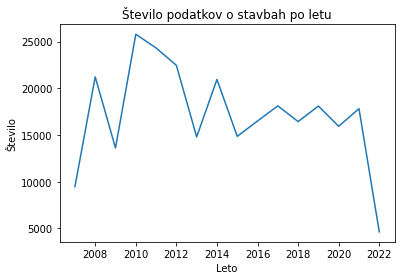

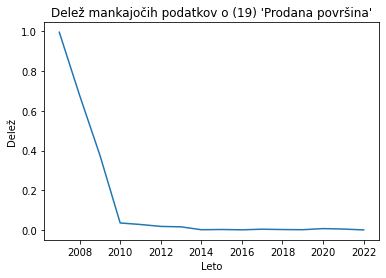

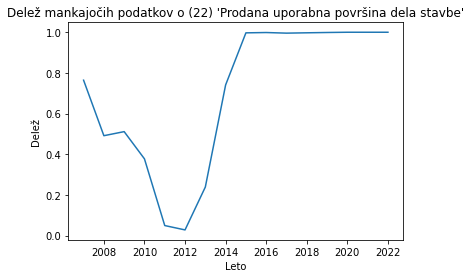

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(2007,2023),allDataLenVsi)
plt.xlabel("Leto")
plt.ylabel("Število")
plt.title("Število podatkov o stavbah po letu")
plt.show()

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(2007,2023),manka19Vsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Delež mankajočih podatkov o (19) 'Prodana površina'")
plt.show()

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(2007,2023),manka22Vsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Delež mankajočih podatkov o (22) 'Prodana uporabna površina dela stavbe'")
plt.show()

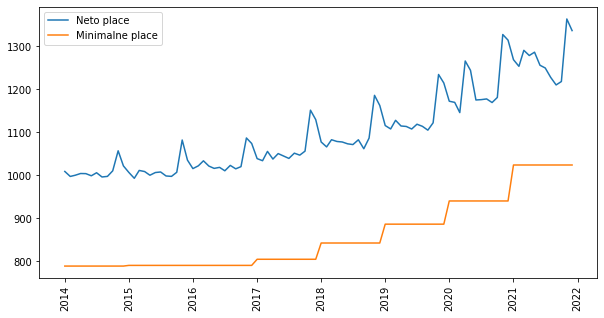

In [23]:
from datetime import datetime

seznam = []
for leto in range(2014,2022):
    for mesec in range(1,13):
        seznam.append(datetime.strptime(str(leto)+"-"+str(mesec), '%Y-%m'))


matrika = np.array([[seznam,bruto,neto]], dtype = object)
minPlace =[]
for key in leto_min_placa.keys():
    if int(key) >= 2014:
        minPlace.append(leto_min_placa[key])

minPlace = np.repeat(minPlace, 12)
minPlace = np. reshape(minPlace.astype(float), -1)
  
bruto1 =  np. reshape(matrika[:,1].astype(float), -1)
neto1 = np. reshape(matrika[:,2].astype(float), -1)
y = np. reshape(matrika[:,0].astype(datetime), -1)

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
#plt.plot(y,bruto1, label="Bruto place")
plt.plot(y,neto1, label="Neto place")
plt.plot(y,minPlace,label ="Minimalne place")

plt.legend()
plt.xticks(rotation=90)
plt.show()

#print(y)

Graf prikazuje obnašanje prihodkov skozi obdobje 2014 do 2022. Razberemo lahko, da prihodki počasi rastejo, tako povprečna, kot tudi minimalna, kar je logično. Opažamo lahko skoke v koncih vsakega leta. Te skoke najverjetneje povzročijo božični bonusi.

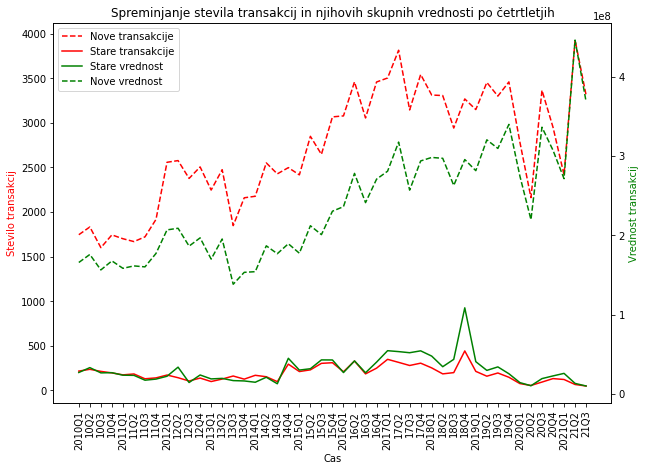

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
fig.patch.set_facecolor('white')
ax.set_title("Spreminjanje stevila transakcij in njihovih skupnih vrednosti po četrtletjih")
ax.tick_params('x', labelrotation=90)
ax.set_xlabel('Cas')
ax.set_ylabel('Stevilo transakcij', color="red")

# Plot linear sequence, and set tick labels to the same color
pom1, =ax.plot(xVrednosti,noveTransakcije, 'r--')
pom2, =ax.plot(stareTransakcije, 'r')
ax.tick_params(axis='y')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.set_ylabel('Vrednost transakcij', color="green")
pom3, =ax2.plot(stareVrednost, color='green')
pom4, =ax2.plot(noveVrednost, 'g--')
ax2.tick_params(axis='y')

ax.legend([pom1,pom2,pom3,pom4],
          ['Nove transakcije','Stare transakcije','Stare vrednost','Nove vrednost'])

plt.show()

In [25]:
razlicneRegi = {}
for i in range(2007,2023):
    razlicneRegi[i] = (0, 0)
    dictPosli = getDictPosli(EtnRead(i,'posli'))
    dictStavbe = getDictStavbe(EtnRead(i,'delistavb'))
    for id in dictPosli.keys():
        if id in dictStavbe:
            razl = not isteRegije(dictStavbe[id][1]) 
            razlicneRegi[i] = (razlicneRegi[i][0] + razl ,razlicneRegi[i][1] + 1) # stevilo poslov z stavbami v razlicnih regijah, vsota

In [26]:
print("Kolikokrat se je kot del enega posla kupilo nepremičnine (stanovanje, stanovalsko hišo) iz več regij:")
for leto,data in razlicneRegi.items():
    print(f"{leto}: {str(data[0]).rjust(2)} / {str(data[1]).rjust(5)}  {'{0:.2f}'.format(round(data[0]/data[1]*100,2))}%")

Kolikokrat se je kot del enega posla kupilo nepremičnine (stanovanje, stanovalsko hišo) iz več regij:
2007:  0 /    43  0.00%
2008:  0 /  3904  0.00%
2009:  2 /  5234  0.04%
2010:  2 / 13491  0.01%
2011:  0 / 13939  0.00%
2012:  1 / 13764  0.01%
2013:  1 / 10655  0.01%
2014:  0 / 15668  0.00%
2015:  0 / 13563  0.00%
2016:  0 / 15605  0.00%
2017:  2 / 16891  0.01%
2018: 17 / 15389  0.11%
2019: 24 / 16995  0.14%
2020: 32 / 14861  0.22%
2021: 35 / 16380  0.21%
2022: 13 /  4233  0.31%


In [27]:
def grafStevilaPoslov():

    data_poslov = {}

    for leto,data in razlicneRegi.items():
        data_poslov[leto] = data[1]

    plt.plot(data_poslov.keys(),data_poslov.values())

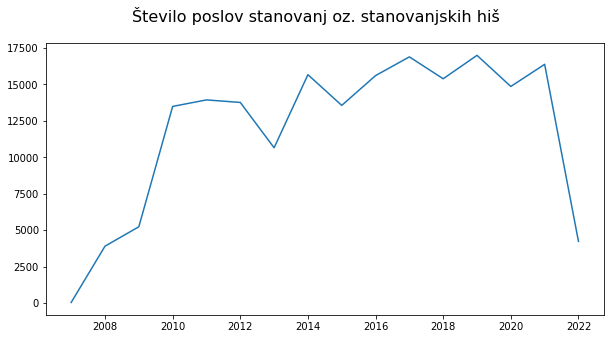

In [28]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Število poslov stanovanj oz. stanovanjskih hiš' , fontsize=16)
fig.patch.set_facecolor('white')
grafStevilaPoslov()
plt.show()

In [29]:
def grafRegijePoCeni(regija):
    cene = []
    stevila = []
    leta= []
    for key in regijskiMeter.keys():
        cena, stevilo = regijskiMeter[key][regija]
        cene.append(cena)
        stevila.append(stevilo)
        leta.append(key)
    
    plt.plot(leta,cene, label=regija)

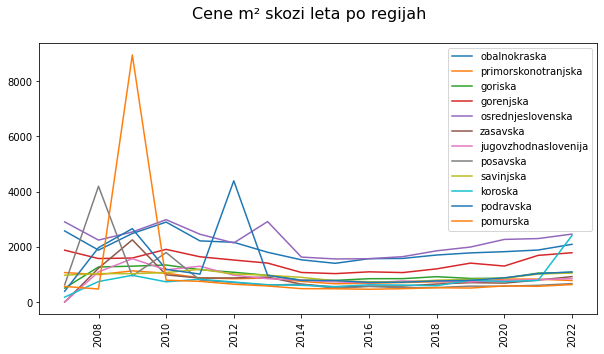

In [30]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Cene m² skozi leta po regijah' , fontsize=16)
fig.patch.set_facecolor('white')
for key in regije.keys():
    grafRegijePoCeni(key)
bottom,top = plt.ylim()
#plt.ylim(-500, top-27000)
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [31]:
#izražanje cen v povprečnih neto plačah
def grafRegijePoMinPlacah(regija):
    cene = []
    #stevila = []
    leta= []
    for leto in regijskiMeter.keys():
        if(2010 <= leto <= 2021):
            cena, stevilo = regijskiMeter[leto][regija]
            cene.append(cena/float(leto_min_placa[str(leto)])*100)
            #stevila.append(stevilo)
            leta.append(leto)
    
    plt.plot(leta,cene, label=regija)
    
    return (leta,cene)
    
def grafRegijePoPovpNetoPlacah(regija):
    cene = []
    #stevila = []
    leta= []
    for leto in regijskiMeter.keys():
        if(2014 <= leto <= 2021):
            cena, stevilo = regijskiMeter[leto][regija]
            cene.append(cena/float(neto1[leto-2014])*100)
            #stevila.append(stevilo)
            leta.append(leto)
    
    plt.plot(leta,cene, label=regija)
    
    return (leta,cene)


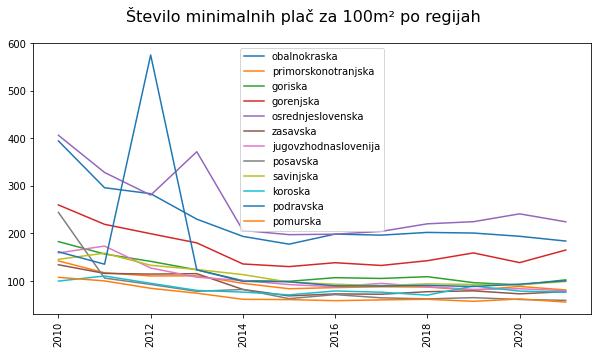

In [32]:
#risanje grafa po min placah
letaMin = None
seznamMin = {}
fig = plt.figure(figsize=(10,5))
fig.suptitle('Število minimalnih plač za 100m² po regijah' , fontsize=16)
fig.patch.set_facecolor('white')
for key in regije.keys():
    letaMin, faktor = grafRegijePoMinPlacah(key)
    seznamMin[key]=faktor
plt.legend()
plt.xticks(rotation=90)
plt.show()

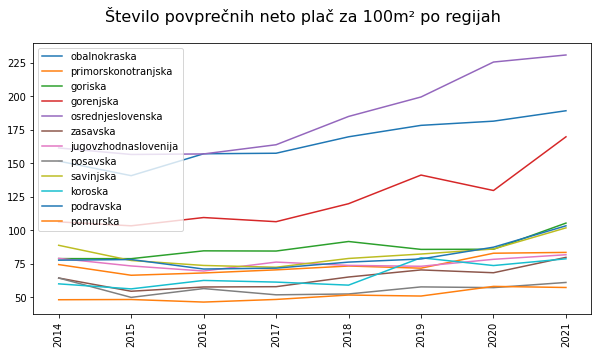

In [33]:
#risanje grafa po povprecnih placah
letaNeto = None
seznamNeto = {}
fig = plt.figure(figsize=(10,5))
fig.suptitle('Število povprečnih neto plač za 100m² po regijah' , fontsize=16)
fig.patch.set_facecolor('white')
for key in regije.keys():
    letaNeto,faktor = grafRegijePoPovpNetoPlacah(key)
    seznamNeto[key]=faktor
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [34]:
povrsineRegija = {}
for i in range(2007,2023):
    povrsineRegija[i] = {reg : [] for reg in regije.keys()}
    povrsineRegija[i]["Brez"] = []
    dictPosli = getDictPosli(EtnRead(i,'posli'))
    dictStavbe = getDictStavbe(EtnRead(i,'delistavb'))
    for id in dictPosli.keys():
        if id in dictStavbe:
            povrsineRegija[i][ whichRegija( dictStavbe[id][1][0] ) ].append( dictStavbe[id][0] / len(dictStavbe[id][1]) )

In [35]:
#Povprecne povrsine po regijah
avgPovrsinaPoRegijah = { reg : [] for reg in regije.keys() }
avgPovrsinaPoRegijah["Brez"] = []

for leto in povrsineRegija.keys():
    for reg in povrsineRegija[leto].keys():
        pSeznam = povrsineRegija[leto][reg]
        if len(pSeznam) == 0:
            avgPovrsinaPoRegijah[reg].append(0)
        else:
            avgPovrsinaPoRegijah[reg].append( sum( povrsineRegija[leto][reg] ) / len( povrsineRegija[leto][reg] ) )
        #print(f"{reg.ljust(20)} {round(avgPovrsinaPoRegijah[leto][reg],4)}")

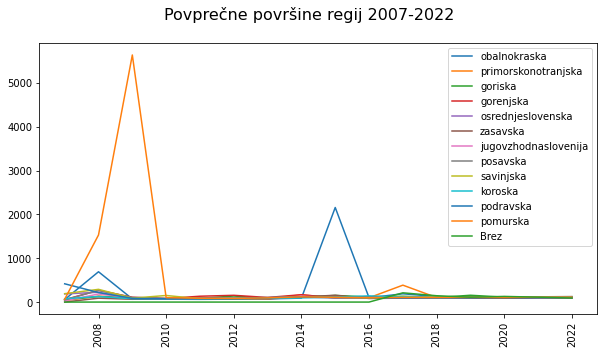

In [36]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Povprečne površine regij 2007-2022' , fontsize=16)
fig.patch.set_facecolor('white')
for key, value in avgPovrsinaPoRegijah.items():
    plt.plot(range(2007,2023),value, label=key)
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [37]:
def kolikoPlacPovprecno(povrsine,placNaM,naslov):
    fig, ax = plt.subplots(1, 2, figsize=(20, 12))
    #ax[0] = fig.add_axes([0,0,1,1])

    ax[0].set_title(naslov , fontsize=16)
    
    fig.patch.set_facecolor('white')
    
    faktorPoRegiji = {}

    pomPNM={}
    for key, _ in placNaM.items():
        pomPNM[key] = sum(placNaM[key]) / len(placNaM[key])

    pomPNM = dict(sorted(pomPNM.items(), key=lambda item: item[1], reverse= True))

    for key in pomPNM.keys():
        faktorPoRegiji[key] = float(povrsine[key]) * pomPNM[key]


    faktorPoRegiji = dict(sorted(faktorPoRegiji.items(), key=lambda item: item[1], reverse= False))

    ax[0].barh(list(faktorPoRegiji.keys()),list(faktorPoRegiji.values()))

    plt.xticks(rotation=90)

    #--------------------------------------------
    
    pom = dict(sorted(avgPovrsinaPoRegijah.items(), key=lambda item: item[1], reverse=True))
    ax[1].set_title("Povprečne površine regij" , fontsize=16)
    
    ax[1].bar(pom.keys(), pom.values(), color="lightgreen")

    
    plt.show()

In [38]:
#kolikoPlacPovprecno(avgPovrsinaPoRegijah,seznamMin,"Število min. plač na povprečno površino")

In [39]:
#kolikoPlacPovprecno(avgPovrsinaPoRegijah,seznamNeto,'Število povprečne neto plače na povprečno površino')

Zgornji graf prikazuje rast števila transakcij in njihovih skupnih vrednosti po četrtletjih od leta 2010 do leta 2021. Spodnji del grafa prikazuje podatke za rabljene nepremičnine, zgonrji del pa podatke za nove nepremičnine. Zeleni črti prikazujeta vrednosti transakcij, rdeči lrti pa število transakcij. Razberemo lahko, da je število transakcij novih nepremičnin veliko večje, kot starih. Lahko sklepamo, da se gradnja novih nepremičnin veča, ali pa da se stare nepremičnine ne prodajajo. Lahko sta pa tudi oba primera razlog za razmik. Razberemo lahko tudo da vrednosti sledita trendom števila transakcij. Če število transakcij raste, raste tudi skupna vrednost, kar je logično. Razberljiva sta tudi padca, še predvsem pri novih nepremičninah v času dveh večjih valov okuženosti z COVID-om. Takrat je prodaja padla še posebej pa se padec pozna pri novih nepremičninah, kjer je najverjetneje padla tudi gradnja novih nepremičnin. Kljub padcem se graf novih premičnin hitro vrne nazaj, k svojem trendu naraščanja. Glede rabljenih nepremičnin pa lahko vidimo, da sta od 2010 do 2014 število ter vrednost padala, nato naraščala do leta 2018, in sedaj spet padata. Iz zgornjega dela, ki prikazuje podatke za nove nepremičnine lahko opazimo, da je skupna vrednost transkacij bolj narasla kot število transakcij. Iz tega lahko sklepamo, da se je cena posameznih transakcij povečala.

Dodatne funkcije

In [40]:
def sizeof_fmt(num, suffix="B"): #funkcija za formatiranje izpisa velikosti spremenljivk
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

#preveri katerih podatkov ne more prebrati 
def checkRAM(ime):
    for i in range(2007,2023):
        try:
            data = EtnRead(i,ime)
            size = sizeof_fmt(sys.getsizeof(data))
            print(f"{i} => {data.dtype}, ram usage: {size}") #preveri tip tabele ie string length
            del data
        except Exception as e:
            print(f"{i} => {e}")  #prikazi katero leto ti vrže (memoryError -> zmankal rama) exception 
            pass

def test():
    print('delistavb')
    checkRAM('delistavb')
    print()

    print('zemljisca')
    checkRAM('zemljisca')
    print()

    print('posli')
    checkRAM('posli')
    
#test()

In [41]:
def _zemljisca():       #fix ce mislis use
    dict_zemljisca = {}
    for row in zemljisca2010:
        if row[10] == '' or int(row[10]) == '0': # če ni površine preskoči
            continue
        if row[5] not in (1,2,3,4): #ce ni primernega tipa za stanovanje oz hišo nas ne zanima
            pass
            #continue
        if "/" in row[8]: # row[8] != 'NP' and row[8] != '6179844811' and row[8] != '': #preveri pomen NP, ali je Ni Podatka ali kaj
            ops = row[8].split("/") 
        else:
            ops = ['1', '1']
        
        if ops[0] == '':
            ops[0] = 1
        if ops[1] == '':
            ops[1] = 1

        prodanDelez = int(ops[0]) / int(ops[1])

        if prodanDelez == 0:
            continue


        povrsinaParcele = float(row[10].replace(",","."))
        if row[0] in dict_zemljisca:
            dict_zemljisca[row[0]]+= povrsinaParcele #* prodanDelez
        else:
            dict_zemljisca[row[0]] = povrsinaParcele #* prodanDelez

# Zaključek

Do sedaj smo pregledali podatje o plačah in nepremičninah. Vidimo rast v obeh primerih, vendar če hočemo odgovoriti na naše vprašanje moramo to rast še dodatno primerjati med seboj. V nadaljevanju projektne naloge želimo bolje pregledati trende pri nepremičninah, kar bomo storili s pomočjo podatkov evidence trga nepremičnin. Želeli bi boljšo predstavitev glede na regije in boljšo razdelitev glede na tip nepremičnine.